In [124]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\
import polars as pl
from IPython.display import clear_output
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os, gc, re


from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


## Features Documentation
* session_id - the ID of the session the event took place in
* index - the index of the event for the session
* elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
* event_name - the name of the event type
* name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
* level - what level of the game the event occurred in (0 to 22)
* page - the page number of the event (only for notebook-related events)
* room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
* room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
* screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
* screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
* hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
* text - the text the player sees during this event
* fqid - the fully qualified ID of the event
* room_fqid - the fully qualified ID of the room the event took place in
* text_fqid - the fully qualified ID of the
* fullscreen - whether the player is in fullscreen mode
* hq - whether the game is in high-quality
* music - whether the game music is on or off
* level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

-----------------------------------------------------------------------------------------------------------------------

## What am I predicting?
For each <session_id>_<question #>, you are predicting the correct column, identifying whether you believe the user for this particular session will answer this question correctly, using only the previous information for the session.

The timeseries API presents the questions and data to you in order of levels - level segments 0-4, 5-12, and 13-22 are each provided in sequence, and you will be predicting the correctness of each segment's questions as they are presented.

In [60]:

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [61]:
train_path = "/kaggle/input/predict-student-performance-from-game-play/train.csv"
label_path = "/kaggle/input/predict-student-performance-from-game-play/train_labels.csv"
test_path = "/kaggle/input/predict-student-performance-from-game-play/test.csv"

In [62]:
chunk_size = 1000000  # Adjust this value based on your system memory
train_df = pd.DataFrame() # Initialize an empty DataFrame to store the processed data


# Read the CSV file in chunks
label_df = pd.read_csv( label_path )
test_df = pd.read_csv( test_path )

for chunk in pd.read_csv( train_path, chunksize=chunk_size ):

    # Append the processed chunk to the final DataFrame
    train_df = train_df.append(chunk, ignore_index=True)
    train_df = reduce_memory_usage(train_df)
    print("Training Shape: ", train_df.shape)
    clear_output( wait=True )
    if train_df.shape[0] > 100000:
        break

print("Done Reading Data")
print("Test data: ", test_df.shape)
print("Train data: ", train_df.shape)
print("label data: ", label_df.shape)

Done Reading Data
Test data:  (3728, 21)
Train data:  (1000000, 20)
label data:  (424116, 2)


# Exploratory Data Analysis

<AxesSubplot:>

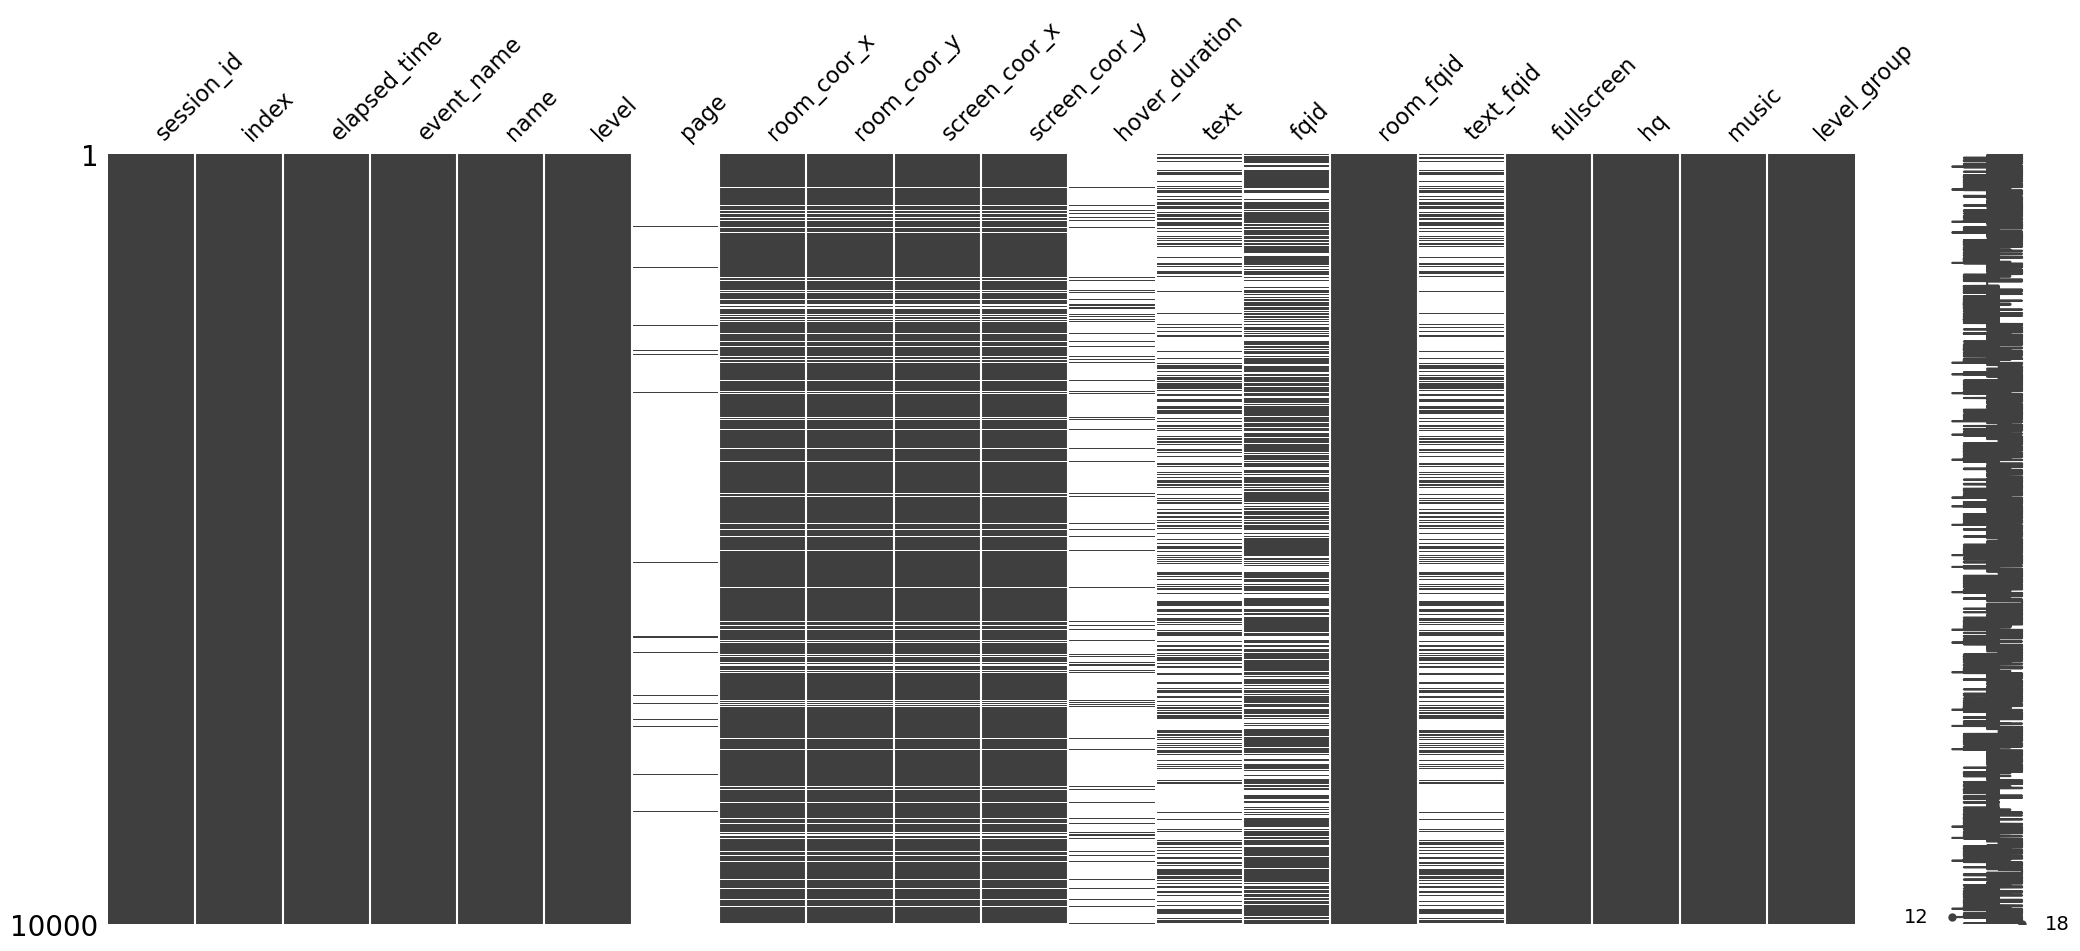

In [63]:
msno.matrix(train_df.iloc[:10000, :])

<AxesSubplot:>

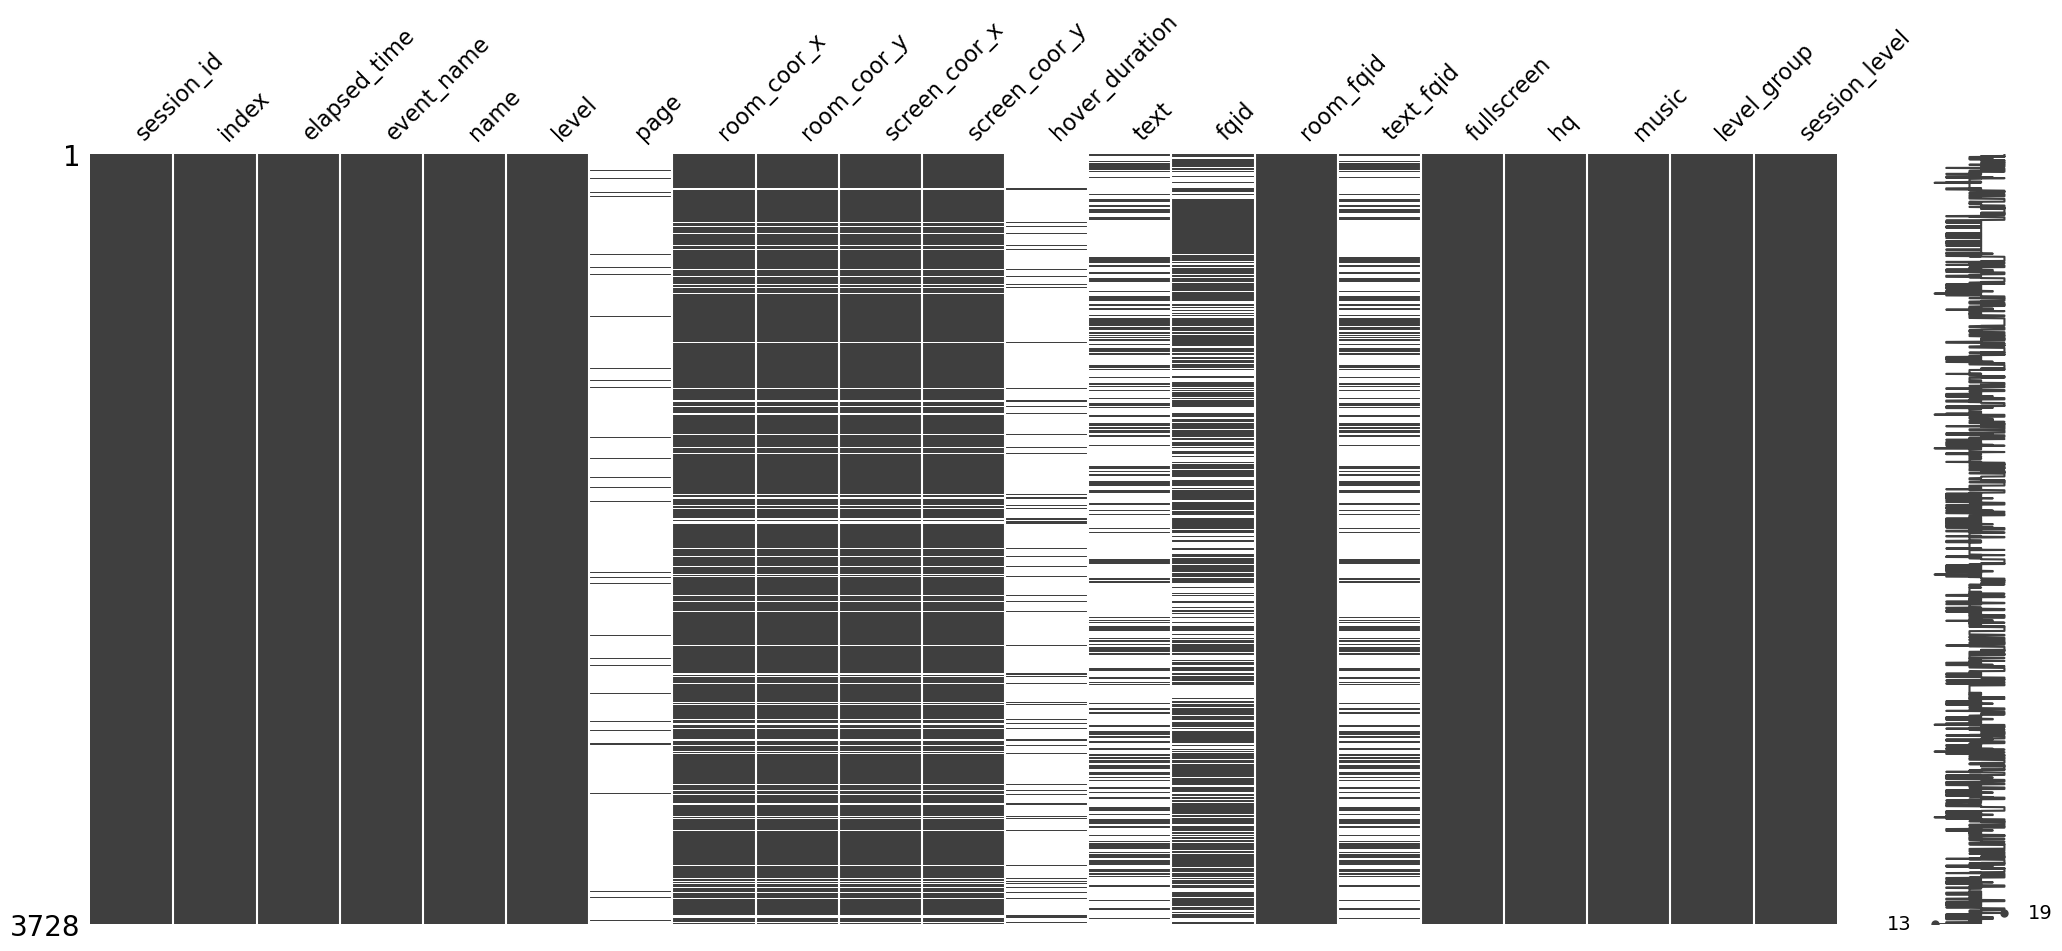

In [64]:
msno.matrix(test_df)

<AxesSubplot:>

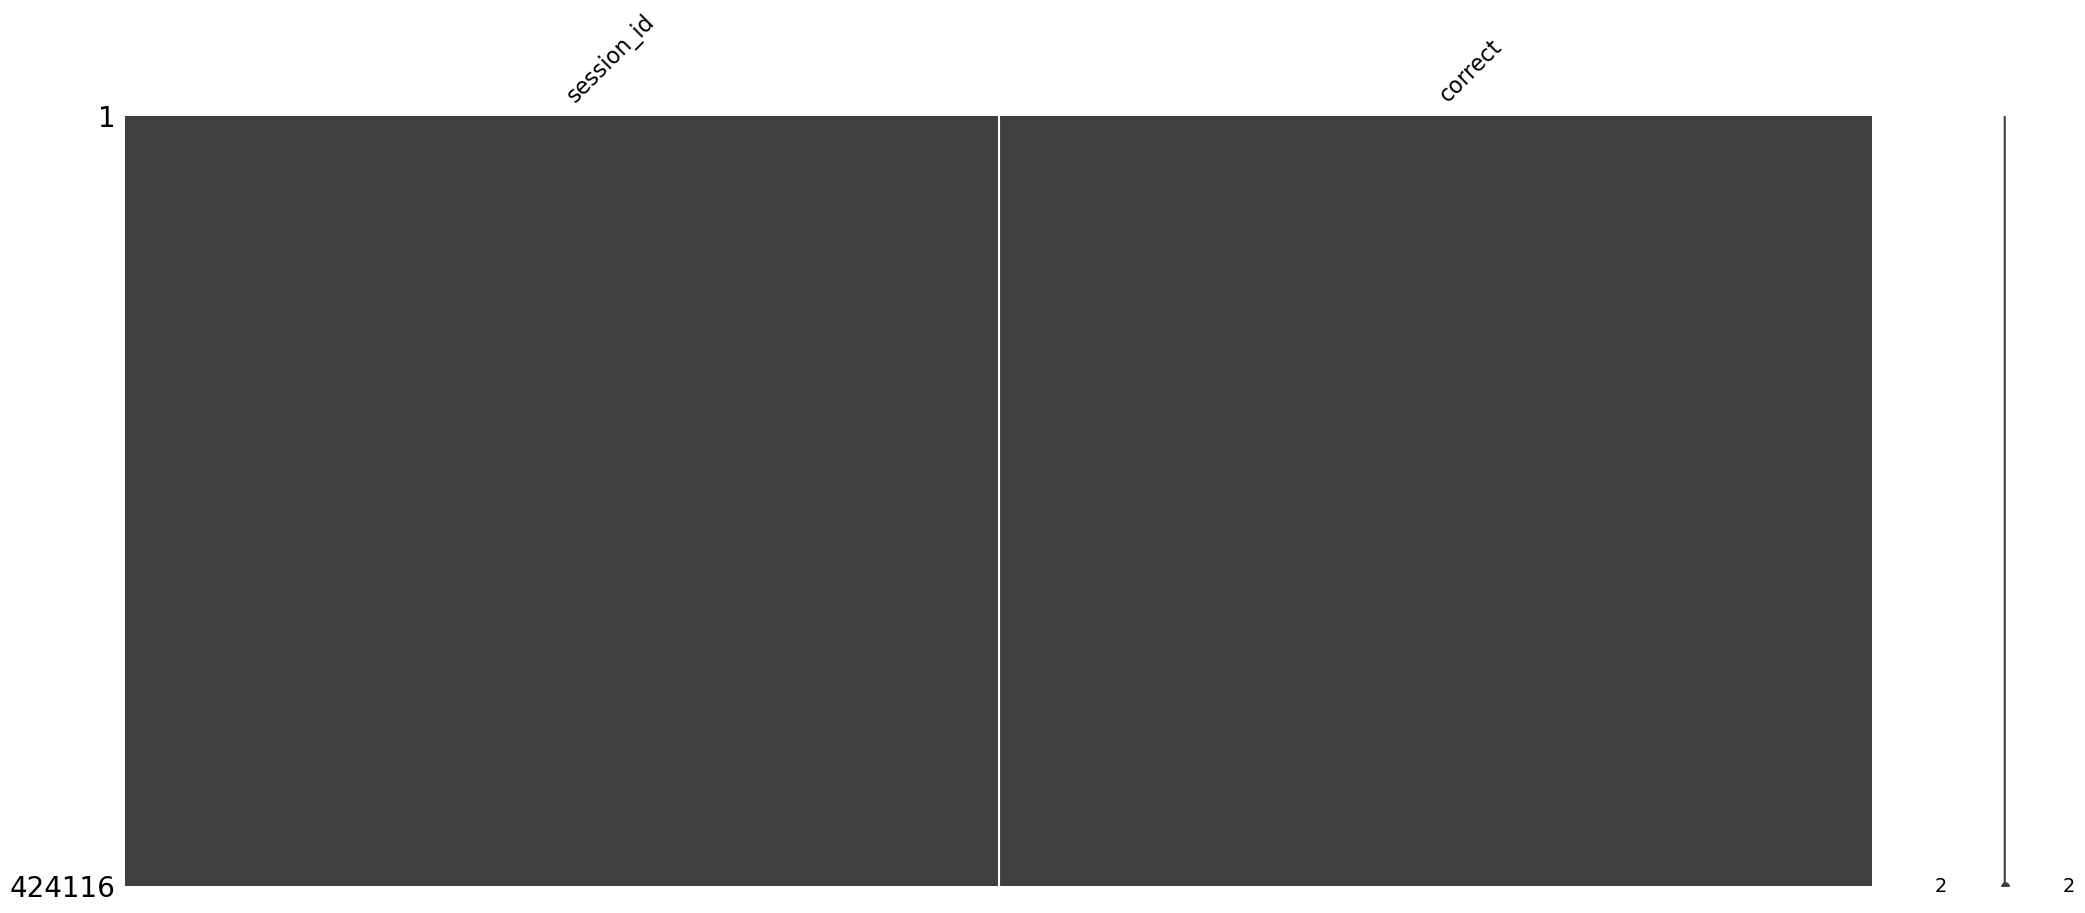

In [65]:
msno.matrix(label_df)

In [66]:
# drop the null and irrelevant columns from test and train dataset
drop_columns = ['page' , 'hover_duration' , 'text' , 'text_fqid', 'music']
train_df.drop( columns = drop_columns , inplace = True)
test_df.drop( columns = drop_columns , inplace = True)

# Separate both values
label_df[['session_id', 'q']] = label_df.session_id.str.split('_', expand=True)

# Conver the columns into neccessary types
label_df.session_id = label_df.session_id.astype('int64')
label_df.q = label_df.q.str.strip('q').astype('int8')

In [67]:
train_df['session_id'].value_counts()

20100114224046390    4174
20100017221780384    3114
20100215321524424    2906
20100111522448010    2780
20100118090535520    2776
                     ... 
20100216311459110     683
20100209514133092     664
20100111111155972     655
20100119192145600     651
20100412013046310      39
Name: session_id, Length: 886, dtype: int64

(600.0, 2000.0)

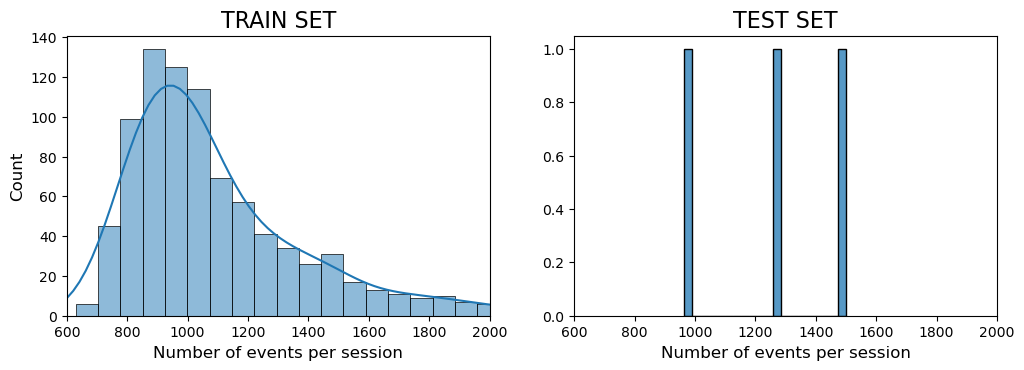

In [68]:
Events_per_session_train = train_df['session_id'].value_counts()
Events_per_session_test = test_df['session_id'].value_counts()


plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(Events_per_session_train.values, kde=True)
plt.xlabel("Number of events per session", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("TRAIN SET", fontsize=16)
plt.xlim(600, 2000)

plt.subplot(2, 2, 2)
sns.histplot(Events_per_session_test.values, bins=20)
plt.xlabel("Number of events per session", fontsize=12), plt.ylabel("")
plt.title("TEST SET", fontsize=16)
plt.xlim(600, 2000)


Text(0.5, 1.0, 'Question Level Answered by Most of the Users')

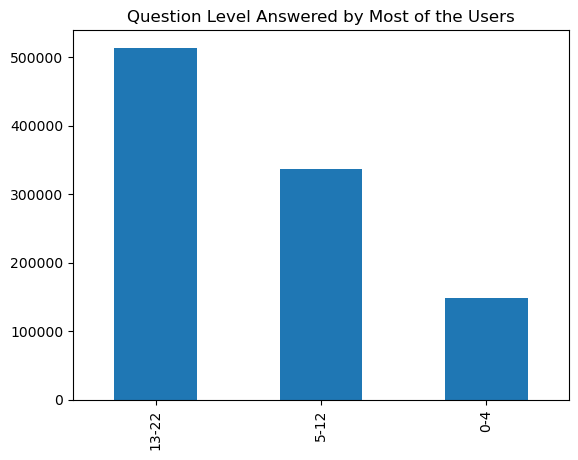

In [69]:
# which categories have been answered by the user the most
train_df['level_group'].value_counts().plot( 
        kind = 'bar'
    )
plt.title('Question Level Answered by Most of the Users')

In [70]:
gc.collect()

129

# Feature Engineering

In [71]:
oneHotEncoding = ['event_name' , 'name'] # Need to encode these features
numercial_sum_features = [] # Will be using these features to for sum on group by

# Encoding 
for feature in oneHotEncoding:
    encoded_df = pd.get_dummies(train_df[feature])
    train_df = pd.concat([train_df, encoded_df], axis=1)
    
    numercial_sum_features.append( encoded_df.columns.tolist() )
    
numercial_sum_features = sum( numercial_sum_features, [] ) # final single list

In [72]:
numercial_sum_features

['checkpoint',
 'cutscene_click',
 'map_click',
 'map_hover',
 'navigate_click',
 'notebook_click',
 'notification_click',
 'object_click',
 'object_hover',
 'observation_click',
 'person_click',
 'basic',
 'close',
 'next',
 'open',
 'prev',
 'undefined']

In [73]:
train_df.columns
train_df.shape

(1000000, 32)

In [74]:
categorical_features = ['event_name' , 'name', 'fqid', 'room_fqid']
numercial_features = [ 'elapsed_time', 'level' , 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']

In [75]:
def create_feature_set( train_df, categorical_features = None, 
                       numercial_features = None, 
                       numercial_sum_features = None ):
    df = pd.DataFrame()
    for feature in categorical_features:
        df = train_df.groupby(['session_id','level_group'])[feature].agg('nunique').reset_index()
        
    for feature in numercial_features:
        df[f'{feature}_mean'] = train_df.groupby(['session_id','level_group'])[feature].agg('mean').reset_index()[feature]
        df[f'{feature}_max'] = train_df.groupby(['session_id','level_group'])[feature].max().reset_index()[feature]
        df[f'{feature}_min'] = train_df.groupby(['session_id','level_group'])[feature].min().reset_index()[feature]

    for feature in numercial_sum_features:
        df[f'{feature}_sum'] = train_df.groupby(['session_id','level_group'])[feature].agg('sum').reset_index()[feature]
        
    df.filter( regex= '_min|_max|_sum|_mean|n_' ).fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')

    return df

In [76]:
df = create_feature_set( train_df , categorical_features, numercial_features, numercial_sum_features )
df

,index,level_group,room_fqid,elapsed_time_mean,elapsed_time_max,elapsed_time_min,level_mean,level_max,level_min,room_coor_x_mean,...,object_click_sum,object_hover_sum,observation_click_sum,person_click_sum,basic_sum,close_sum,next_sum,open_sum,prev_sum,undefined_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0,0-4,7,8.579356e+04,194860.0,0.0,1.945455,4.0,0.0,7.687500,...,11.0,4,4,22.0,74.0,6,0,0,0,85.0
20090312431273200,1,13-22,12,1.040601e+06,1272679.0,836732.0,17.402381,22.0,13.0,-130.375000,...,20.0,13,3,123.0,228.0,5,0,0,0,187.0
20090312431273200,2,5-12,11,3.572052e+05,499235.0,221485.0,8.054054,12.0,5.0,14.304688,...,28.0,21,1,104.0,161.0,6,0,0,0,129.0
20090312433251036,3,0-4,6,9.763342e+04,233752.0,0.0,1.870504,4.0,0.0,-84.062500,...,15.0,5,2,18.0,77.0,5,0,1,0,56.0
20090312433251036,4,13-22,16,2.498852e+06,3815334.0,1176483.0,17.762529,22.0,13.0,-30.750000,...,83.0,66,5,145.0,504.0,39,1,19,1,733.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20100412005177230,2653,13-22,13,1.152992e+06,1484779.0,834773.0,16.943005,22.0,13.0,-173.750000,...,17.0,12,7,132.0,263.0,10,0,0,0,306.0
20100412005177230,2654,5-12,11,4.133706e+05,597181.0,219095.0,8.445141,12.0,5.0,-13.226562,...,47.0,34,2,120.0,198.0,5,0,0,0,116.0
20100412013046310,2655,0-4,3,3.609503e+04,83131.0,0.0,0.230769,1.0,0.0,-183.125000,...,3.0,0,3,10.0,21.0,3,0,1,0,14.0


In [77]:
print("Total Features we have: ", df.shape[1])

Total Features we have:  38


# Model Training

Fold:  0
--> Training Questions:  1
--> Training Questions:  2
--> Training Questions:  3
--> Training Questions:  4
--> Training Questions:  5
--> Training Questions:  6
--> Training Questions:  7
--> Training Questions:  8
--> Training Questions:  9
--> Training Questions:  10
--> Training Questions:  11
--> Training Questions:  12
--> Training Questions:  13
--> Training Questions:  14
--> Training Questions:  15
--> Training Questions:  16
--> Training Questions:  17
--> Training Questions:  18
Fold:  1
--> Training Questions:  1
--> Training Questions:  2
--> Training Questions:  3
--> Training Questions:  4
--> Training Questions:  5
--> Training Questions:  6
--> Training Questions:  7
--> Training Questions:  8
--> Training Questions:  9
--> Training Questions:  10
--> Training Questions:  11
--> Training Questions:  12
--> Training Questions:  13
--> Training Questions:  14
--> Training Questions:  15
--> Training Questions:  16
--> Training Questions:  17
--> Training Questio

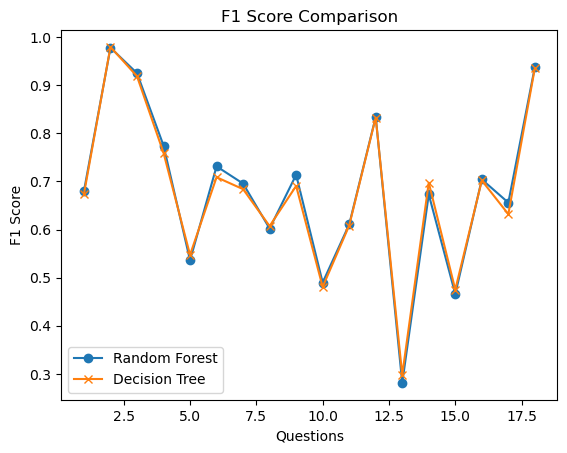

In [121]:
# Define variables
groupFold = GroupKFold(n_splits=5)
ALL_USERS = df.index.unique()
oof_rf = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index=ALL_USERS)
oof_dt = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index=ALL_USERS)
modeling_features = df.columns[2:]
df[modeling_features] = df[modeling_features].fillna(-1)
models_rf = {}
models_dt = {}

# Initialize F1 score lists for both models
f1_scores_rf = []
f1_scores_dt = []

for i, (train_index, test_index) in enumerate(groupFold.split(X=df, groups=df.index)):

    print("Fold: ", i)
    # Train the model iteratively for each of the 18 questions
    for t in range(1, 19):
        print("--> Training Questions: ", t)

        if t>0 and t<=3: 
            grp = '0-4'
        elif t<=13: 
            grp = '5-12'
        elif t<=22: 
            grp = '13-22'

        # Training Data
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = label_df.loc[label_df.q==t].set_index('session_id').loc[train_users]

        # Testing Data
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = label_df.loc[label_df.q==t].set_index('session_id').loc[valid_users]

        # Model Training - Random Forest
        clf_rf = RandomForestClassifier()
        clf_rf.fit(train_x[modeling_features].astype('float32'), train_y['correct'])

        # Model Training - Decision Tree
        clf_dt = DecisionTreeClassifier()
        clf_dt.fit(train_x[modeling_features].astype('float32'), train_y['correct'])

        # SAVE MODEL, PREDICT VALID OOF - Random Forest
        models_rf[f'{grp}_{t}'] = clf_rf
        oof_rf.loc[valid_users, t-1] = clf_rf.predict_proba(valid_x[modeling_features].astype('float32'))[:, 1]

        # SAVE MODEL, PREDICT VALID OOF - Decision Tree
        models_dt[f'{grp}_{t}'] = clf_dt
        oof_dt.loc[valid_users, t-1] = clf_dt.predict_proba(valid_x[modeling_features].astype('float32'))[:, 1]

        # Compute F1 scores for each model
        f1_rf = f1_score(valid_y['correct'], oof_rf.loc[valid_users, t-1].round(), average='macro')
        f1_dt = f1_score(valid_y['correct'], oof_dt.loc[valid_users, t-1].round(), average='macro')
        f1_scores_rf.append(f1_rf)
        f1_scores_dt.append(f1_dt)

# Plot F1 scores of both models on a line graph
questions = list(range(1, 19))
plt.plot(questions, oof_rf.sum(axis=0)/oof_rf.shape[0], label='Random Forest', marker='o')
plt.plot(questions, oof_dt.sum(axis=0)/oof_dt.shape[0], label='Decision Tree', marker='x')

plt.xlabel('Questions')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend()
# Set x-axis ticks to be integers
plt.xticks(questions)

plt.show()

In [99]:
# Getting True values of each questions.
actual_df = oof.copy()
for k in range(18):
    temp = label_df.loc[label_df.q == k+1].set_index('session_id').loc[ALL_USERS]
    actual_df[k] = temp.correct.values

In [106]:
"""
    We cannot rely on the default threshold of 0.5, we need to check which threshold provide the better division 
    between precision and recall
    
"""
best_score = 0
best_threshold = 0

for threshold in np.arange(0.5,0.75,0.01):
        
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    score = f1_score(actual_df.values.reshape((-1)), preds, average='macro')   
    
    if score > best_score:
        print( f"--> Threshold: {threshold}, F1Score: {score}" )
        best_score = score
        best_threshold = threshold
        
print("*"*40)
print( f"Best Threshold: {best_threshold}, Best F1Score: {best_score}" )

--> Threshold: 0.5, F1Score: 0.6446693663961452
--> Threshold: 0.51, F1Score: 0.6470899365618558
--> Threshold: 0.52, F1Score: 0.6494336754288617
--> Threshold: 0.53, F1Score: 0.6524195396832574
--> Threshold: 0.54, F1Score: 0.657474140098307
--> Threshold: 0.55, F1Score: 0.6580329634359411
--> Threshold: 0.56, F1Score: 0.6583878794481379
--> Threshold: 0.6100000000000001, F1Score: 0.6591110755419376
****************************************
Best Threshold: 0.6100000000000001, Best F1Score: 0.6591110755419376


In [126]:
# COMPUTE F1 SCORE OVERALL
rf_score = f1_score(actual_df.values.reshape((-1)), (oof_rf.values.reshape((-1)) > best_threshold).astype('int'), average='macro')
dt_score = f1_score(actual_df.values.reshape((-1)), (oof_dt.values.reshape((-1)) > best_threshold).astype('int'), average='macro')
print('==> Overall Random Forest Score=', rf_score)
print('==> Overall Decision Tree Classifier Score =', dt_score)

==> Overall Random Forest Score= 0.6584561806706003
==> Overall Decision Tree Classifier Score = 0.5930199976622894
